In [2]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")
library(readxl)
set.seed(5366)

In [3]:
substrRight <- function(x, n){
  substr(x, nchar(x)-n+1, nchar(x))
}

# **Figure 5a: Annotate each GWAS locus based on their QTL types**

## **read information QTL modules**

In [4]:

qtls = read_xlsx("~/projects/Resource/RevisionTables/TableS4.xlsx") %>% 
                filter(QTL_Order == "Primary") %>% 
                mutate(tissue_element = paste(Tissue,Element_ID,sep="_"))


## **read Supplemental Table for GWAS Colocalization**

In [121]:
table = fread("~/projects/Resource/iPSCORE_Multi-QTL_Resource/SourceData/SOURCEDATA.FIGURE5AB.txt", data.table = F) 


In [7]:
coloced = table[ table$QTL_Combination != "",]
length(unique(coloced$Index_Trait))

length(unique(coloced$Index_Trait[ coloced$QTL_Combination_Collapse %in% c("caQTL","haQTL","caQTL-haQTL")]))
length(unique(coloced$Index_Trait[ coloced$QTL_Combination_Collapse %in% c("eQTL")]))

nrow(coloced[ coloced$QTL_Combination_Collapse == "eQTL",])

[1] 540

[1] 347

[1] 183

[1] 261

## **total number of independent loci per trait**

In [8]:
total_signals_per_trait = table %>% select(Trait_Description, GWAS_Index) %>% distinct() %>% dplyr::count(Trait_Description)
total_signals_per_trait

Trait_Description,n
<chr>,<int>
Aging,35
Angina Pectoris,34
Atrial Fibrillation,90
Birth Weight,65
Body Mass Index,1519
Childhood Obesity,14
Fasting Glucose,159
HDL Cholesterol,1837
Ischemic Heart Disease,81


## **aggregate QTL types for each GWAS locus**

In [9]:
toplot = table %>%
            select(Trait_Description, GWAS_Index, QTL_Combination_Collapse, Index_Trait) %>%
            filter(QTL_Combination_Collapse != "") %>%
            distinct() %>%
            group_by(Index_Trait, Trait_Description) %>%
            dplyr::summarise(QTL_Combination_Collapse = paste(QTL_Combination_Collapse, collapse = "-")) 

table(toplot$QTL_Combination_Collapse)

head(toplot,2)

`summarise()` has grouped output by 'Index_Trait'. You can override using the
`.groups` argument.



                            caQTL                  caQTL-caQTL-eQTL 
                              203                                 4 
                caQTL-caQTL-haQTL                        caQTL-eQTL 
                                2                                31 
                 caQTL-eQTL-caQTL       caQTL-eQTL-caQTL-eQTL-haQTL 
                                2                                 3 
                  caQTL-eQTL-eQTL                  caQTL-eQTL-haQTL 
                                6                                 6 
           caQTL-eQTL-haQTL-caQTL       caQTL-eQTL-haQTL-caQTL-eQTL 
                                3                                 4 
caQTL-eQTL-haQTL-caQTL-eQTL-caQTL             caQTL-eQTL-haQTL-eQTL 
                                2                                 6 
                      caQTL-haQTL                 caQTL-haQTL-caQTL 
                               36                                11 
           caQTL-haQTL-caQTL-eQTL

Index_Trait,Trait_Description,QTL_Combination_Collapse
<chr>,<chr>,<chr>
10_103707199_AT_A icd10-I48-both_sexes.meta,Atrial Fibrillation,caQTL-haQTL
10_116829668_G_A continuous-23104-both_sexes-irnt.meta,Body Mass Index,caQTL


## **sort and de-duplicate QTL_Combination_Collapse column**

In [10]:
toplot$QTL_Combination_Collapse = unlist(lapply(toplot$QTL_Combination_Collapse, function(x) { paste(sort(unique(unlist(strsplit(x, "-")))), collapse = "-") }))
table(toplot$QTL_Combination_Collapse)


           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
             203               65               36               52 
            eQTL       eQTL-haQTL            haQTL 
             124               14               46 

## **check non-duplicate GWAS loci**

In [11]:
toplot %>% filter(duplicated(Index_Trait))

Index_Trait,Trait_Description,QTL_Combination_Collapse
<chr>,<chr>,<chr>


## **count GWAS loci per QTL type**

In [12]:
toplot2 = toplot %>% ungroup() %>% group_by(Trait_Description, QTL_Combination_Collapse) %>% dplyr::count()

head(toplot2,4)

Trait_Description,QTL_Combination_Collapse,n
<chr>,<chr>,<int>
Aging,caQTL,2
Aging,caQTL-eQTL,2
Aging,caQTL-eQTL-haQTL,1
Aging,eQTL,2


## **add colums for data labels**

In [13]:
toplot2 = merge(toplot2, total_signals_per_trait %>% dplyr::rename(total = n), by = "Trait_Description") %>%
            mutate(pct = n / total * 100,
                   y_label = paste(Trait_Description, paste0("(Total=", total, ")"), sep = "\n"),
                   QTL_Combination_Collapse = gsub("-", ",", QTL_Combination_Collapse)) %>%
            ungroup() %>% group_by(Trait_Description) %>%
            dplyr::mutate(total_pct_coloc = sum(pct),
                   total_n = sum(n),
                   bar_label = paste0("n=", total_n, "\n", signif(total_pct_coloc, 2), "%")) %>%
            filter(n != 0)
            

In [14]:
head(toplot2,2)

Trait_Description,QTL_Combination_Collapse,n,total,pct,y_label,total_pct_coloc,total_n,bar_label
<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<chr>
Aging,caQTL,2,35,5.714286,Aging (Total=35),20,7,n=7 20%
Aging,"caQTL,eQTL",2,35,5.714286,Aging (Total=35),20,7,n=7 20%


## **set order to traits by increasing number of colocalizations**

In [15]:
order = toplot2 %>% 
    select(y_label, total_pct_coloc) %>% 
    distinct() %>% 
    arrange(desc(total_pct_coloc))

order$y_label

toplot2$y_label = factor(toplot2$y_label, levels = order$y_label)

Adding missing grouping variables: `Trait_Description`


[1] "Ventricular Rate\n(Total=11)"       "Aging\n(Total=35)"                 
 [3] "Birth Weight\n(Total=65)"           "Atrial Fibrillation\n(Total=90)"   
 [5] "Pulse Rate\n(Total=133)"            "Type 2 Diabetes\n(Total=403)"      
 [7] "Angina Pectoris\n(Total=34)"        "Childhood Obesity\n(Total=14)"     
 [9] "Myocardial Infarction\n(Total=21)"  "Ischemic Heart Disease\n(Total=81)"
[11] "Body Mass Index\n(Total=1519)"      "QRS Duration\n(Total=38)"          
[13] "Fasting Glucose\n(Total=159)"       "HDL Cholesterol\n(Total=1837)"     
[15] "LDL Direct\n(Total=752)"

## **set order to qtl types**

In [16]:
qtl_order = c("caQTL", "haQTL", "eQTL", "caQTL,haQTL", "caQTL,eQTL", "eQTL,haQTL", "caQTL,eQTL,haQTL")
toplot2$QTL_Combination_Collapse = factor(toplot2$QTL_Combination_Collapse, levels = qtl_order)

In [17]:
head(toplot2,2)

Trait_Description,QTL_Combination_Collapse,n,total,pct,y_label,total_pct_coloc,total_n,bar_label
<chr>,<fct>,<int>,<int>,<dbl>,<fct>,<dbl>,<int>,<chr>
Aging,caQTL,2,35,5.714286,Aging (Total=35),20,7,n=7 20%
Aging,"caQTL,eQTL",2,35,5.714286,Aging (Total=35),20,7,n=7 20%


## **rename columns**

In [18]:
toplot3 = toplot2 %>%
           dplyr::rename(QTL_Annotations = QTL_Combination_Collapse) %>%
           dplyr::rename(Number_Signals_with_Annotation = n) %>%
           dplyr::rename(Total_Indep_Signals_for_Trait = total) %>%
           dplyr::rename(Pct_Signals_Colocalized_with_Annotation = pct) %>%
           dplyr::rename(Bar_Label = bar_label) %>%
           dplyr::rename(Total_Pct_Colocalized = total_pct_coloc) %>%
           dplyr::rename(Total_Number_Signals_Colocalized = total_n) %>%
           dplyr::rename(Y_label = y_label) 

toplot3 %>% head(5)



Trait_Description,QTL_Annotations,Number_Signals_with_Annotation,Total_Indep_Signals_for_Trait,Pct_Signals_Colocalized_with_Annotation,Y_label,Total_Pct_Colocalized,Total_Number_Signals_Colocalized,Bar_Label
<chr>,<fct>,<int>,<int>,<dbl>,<fct>,<dbl>,<int>,<chr>
Aging,caQTL,2,35,5.714286,Aging (Total=35),20.00000,7,n=7 20%
Aging,"caQTL,eQTL",2,35,5.714286,Aging (Total=35),20.00000,7,n=7 20%
Aging,"caQTL,eQTL,haQTL",1,35,2.857143,Aging (Total=35),20.00000,7,n=7 20%
Aging,eQTL,2,35,5.714286,Aging (Total=35),20.00000,7,n=7 20%
Angina Pectoris,caQTL,2,34,5.882353,Angina Pectoris (Total=34),14.70588,5,n=5 15%


## **prepare data input for plotting QTL types for all GWAS loci**

In [20]:
total_gwas = length(unique(table$Index_Trait))

all = toplot3 %>% 
    ungroup() %>% 
    select(QTL_Annotations, Number_Signals_with_Annotation)  %>%
    mutate(Total_Number_Signals_Colocalized = sum(Number_Signals_with_Annotation)) %>%
    group_by(QTL_Annotations) %>%
    dplyr::mutate(Number_Signals_with_Annotation = sum(Number_Signals_with_Annotation)) %>%
    distinct() %>%
    ungroup() %>%
    mutate(Total_Indep_Signals_for_Trait = total_gwas) %>%
    dplyr::mutate(Pct_Signals_Colocalized_with_Annotation = Number_Signals_with_Annotation / Total_Indep_Signals_for_Trait * 100) %>%
    mutate(Total_Pct_Colocalized = sum(Pct_Signals_Colocalized_with_Annotation)) %>%
    mutate(Bar_Label = paste0("n=", Total_Number_Signals_Colocalized, "\n", signif(Total_Pct_Colocalized, 2), "%")) %>%
    mutate(Y_label = paste0("All 15 Traits\n(Total=", total_gwas, ")"),
           Trait_Description = "All 15 Traits")

all$QTL_Annotations = factor(all$QTL_Annotations, levels = qtl_order)



sum(all$Number_Signals_with_Annotation)

[1] 540

## **remove labels that are too small too see**

In [21]:
toplot3[toplot3$Trait_Description %like% "Body" & toplot3$Number_Signals_with_Annotation %in% 1:10,]$Number_Signals_with_Annotation = NA


In [22]:
toplot3[toplot3$Trait_Description %like% "Diabetes" & toplot3$Number_Signals_with_Annotation %in% 1:5,]$Number_Signals_with_Annotation = NA


In [23]:
toplot3[toplot3$Trait_Description %like% "LDL" & toplot3$Number_Signals_with_Annotation %in% 1:5,]$Number_Signals_with_Annotation = NA
toplot3[toplot3$Trait_Description %like% "HDL" & toplot3$Number_Signals_with_Annotation %in% 1:10,]$Number_Signals_with_Annotation = NA
toplot3[toplot3$Trait_Description %like% "Glucose" & toplot3$Number_Signals_with_Annotation == 1,]$Number_Signals_with_Annotation = NA


## **plot bars for each trait individually**

In [22]:
# horizontal orientation
# psize(w = 20, h = 12)
# p0 = ggplot(toplot3, aes(x = Pct_Signals_Colocalized_with_Annotation, 
#                     y = Y_label, 
#                     fill = QTL_Annotations, 
#                     label = Number_Signals_with_Annotation)) + 
#     geom_bar(stat = "identity", color = "black") + 
#     jn_classic + 
#     theme(
#         legend.text = element_text(size = 20),
#         legend.title = element_text(size = 20),
#         axis.text = element_text(size = 20)
#     ) + xlab("") + ylab("") + 
#     scale_fill_manual(values = c("#b22e18",
#                                  "#87b6db",
#                                  "#fbbc33", 
#                                  "#b57b75",
#                                  "#80b366",
#                                  "#f4cccc",
#                                  "#a38dbe"), 
#                       name = "Colocalized with  ") +
#      geom_text(position = position_stack(vjust = 0.5), size = 8) +
#      geom_text(data = toplot3, 
#                aes(x = Total_Pct_Colocalized, y = Y_label, label = Bar_Label), color = "black",  hjust = -0.2, size = 7) + 
#      xlim(0, 25)

# p0

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_text()`).”


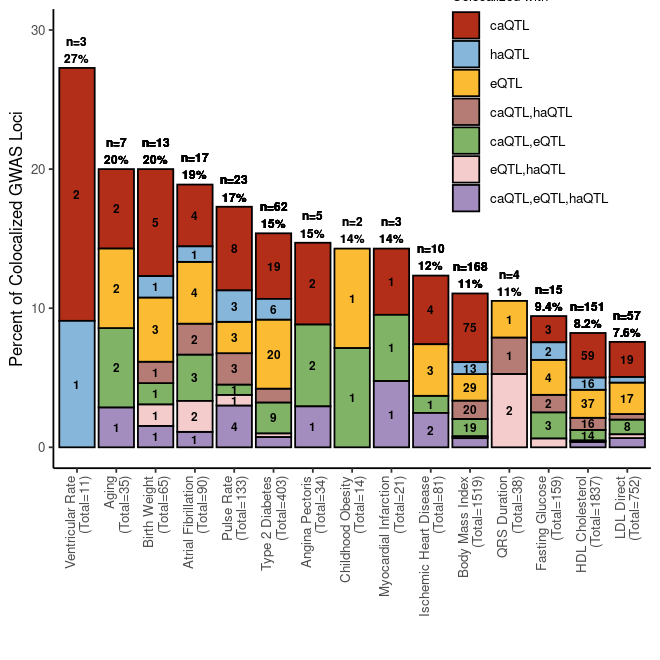

In [32]:
psize(w = 5.5, h = 5.5)
# png("~/projects/Resource/notebooks/toGitHub/figures/figure5a.png",
#    res=300,units="in",width=18,height=15)
p0 = ggplot(toplot3 , 
            aes(y = Pct_Signals_Colocalized_with_Annotation, 
                x = Y_label, 
                fill = QTL_Annotations, 
                label = Number_Signals_with_Annotation)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic + 
    theme(
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8),
        axis.text = element_text(size = 8),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        legend.position = c(0.8, 0.8),
        axis.title.y = element_text(size = 10)
    ) + xlab("") + ylab("Percent of Colocalized GWAS Loci")+
    scale_fill_manual(values = c("#b22e18",
                                 "#87b6db",
                                 "#fbbc33", 
                                 "#b57b75",
                                 "#80b366",
                                 "#f4cccc",
                                 "#a38dbe"), 
                      name = "Colocalized with  ") +
     geom_text(position = position_stack(vjust = 0.5), size = 2.5, fontface = "bold") +
     geom_text(data = toplot3, 
               aes(y = Total_Pct_Colocalized, x = Y_label, label = Bar_Label), color = "black", vjust = -0.2, size = 2.5,fontface = "bold") + 
     ylim(0, 30)

p0
# dev.off()

## **plot all traits together**

In [33]:
all[all$Trait_Description %like% "All" & all$Number_Signals_with_Annotation < 17,]$Number_Signals_with_Annotation = NA


Warning message in geom_text(data = all, aes(y = Total_Pct_Colocalized, x = Y_label, :
“Ignoring unknown parameters: `fill`”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


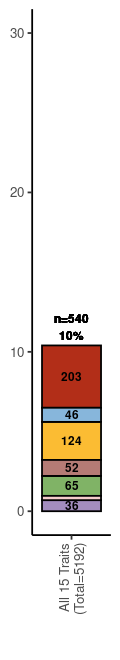

In [37]:
p1 = ggplot(all %>% mutate(Number_Signals_with_Annotation = ifelse(Number_Signals_with_Annotation == 12, NA, Number_Signals_with_Annotation)), aes(y = Pct_Signals_Colocalized_with_Annotation, 
                     x = Y_label, fill = QTL_Annotations, 
                     label = Number_Signals_with_Annotation)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic + 
    theme(
#         legend.position = "none",
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8),
        axis.text = element_text(size = 8),
        legend.position = "none",
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size=8),
        axis.title.y = element_blank()
    ) + xlab("") +
    scale_fill_manual(values = c("#b22e18",
                                 "#87b6db",
                                 "#fbbc33", 
                                 "#b57b75",
                                 "#80b366",
                                 "#f4cccc",
                                 "#a38dbe"), 
                      name = "Colocalized with  ") +
     geom_text(position = position_stack(vjust = 0.5), size = 2.5, fontface = "bold") +
     geom_text(data = all, aes(y = Total_Pct_Colocalized, x = Y_label, label = Bar_Label), 
               color = "black", fill = "black", vjust = -0.2, size = 2.5, fontface = "bold") + 
     ylim(0, 30)

psize(w = 1, h = 5.5)
# png("~/projects/Resource/notebooks/toGitHub/figures/figure5a_all.png",
#    res=300,units="in",width=5,height=15)
p1
# dev.off()


## **combine plots**

In [39]:
psize(w = 6.5, h = 5.5)
p2 = plot_grid(p0 + theme(legend.position = "none"), 
               p1, ncol = 2, align = "hv", rel_widths = c(1, 0.18))

png("~/projects/Resource/figures/Revisions/figure5ab.png",res=300,units="in",width=6.5,height=5.5)
p2
dev.off()

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


pdf 
  2

### reverse order of legend labels

In [27]:
qtl_order = c("caQTL", "haQTL", "eQTL", "caQTL,haQTL", "caQTL,eQTL", "eQTL,haQTL", "caQTL,eQTL,haQTL")
toplot3$QTL_Annotations = factor(toplot3$QTL_Annotations, levels = qtl_order)

### plot using reversed order of colors

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


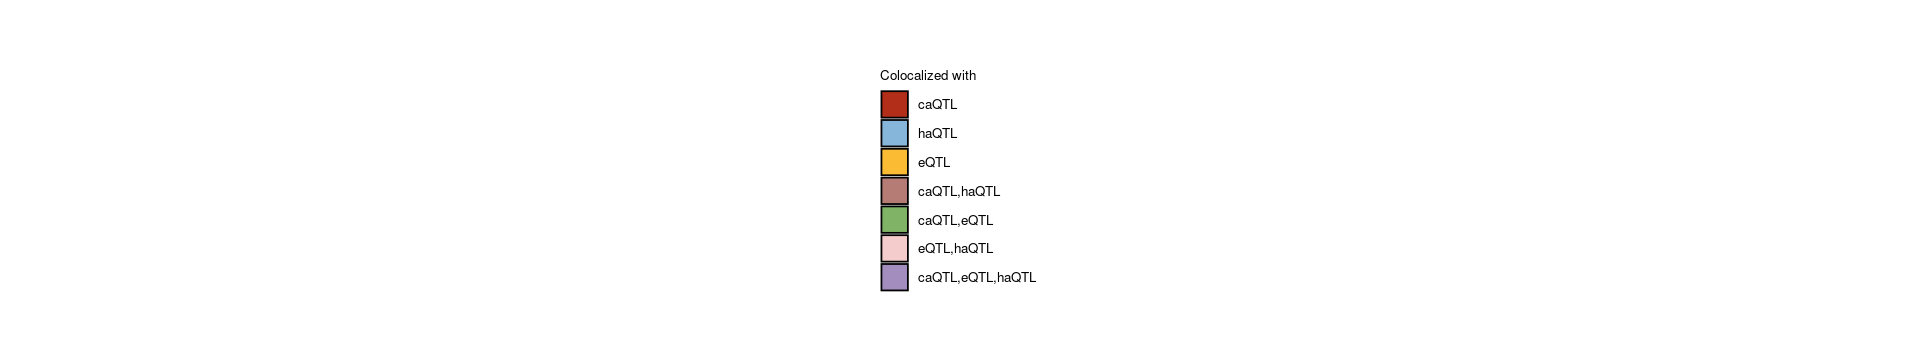

In [40]:
psize(w = 16, h = 3)
p0 = ggplot(toplot3, aes(x = Pct_Signals_Colocalized_with_Annotation, y = Trait_Description, fill = QTL_Annotations, label = Number_Signals_with_Annotation)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic + 
    theme(
#         legend.position = "none",
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8)
    ) + xlab("") + ylab("") + 
    scale_fill_manual(values = c("#b22e18",
                                 "#87b6db",
                                 "#fbbc33", 
                                 "#b57b75",
                                 "#80b366",
                                 "#f4cccc",
                                 "#a38dbe"), 
                      name = "Colocalized with  ") +
     geom_text(position = position_stack(vjust = 0.5), size = 2.5) +
     geom_text(data = toplot3, aes(x = Total_Pct_Colocalized, y = Trait_Description, label = Bar_Label), color = "black",  hjust = -0.2, size = 2.5) + 
     xlim(0, 40)

library(grid)
# png("~/projects/Resource/notebooks/toGitHub/figures/figure5a_legend_v2.png",res=300,units="in",width=3,height=3)
plot_grid(get_legend(p0))
# dev.off()

In [41]:
png("~/projects/Resource/figures/Revisions/figure5ab_legend.png",res=300,units="in",width=3,height=3)
plot_grid(get_legend(p0))
dev.off()

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


pdf 
  2

### Figure 5cd


	Wilcoxon rank sum test with continuity correction

data:  cd_data$distance[cd_data$coloced == "TRUE"] and cd_data$distance[cd_data$coloced == "FALSE"]
W = 1032557, p-value = 1.218e-11
alternative hypothesis: true location shift is not equal to 0


Warning message:
“Removed 604 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


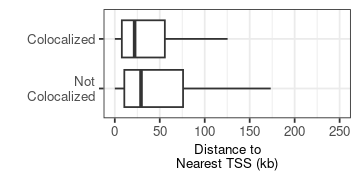

In [101]:
cd_data = fread("~/projects/Resource/iPSCORE_Multi-QTL_Resource/SourceData/SOURCEDATA.FIGURE5CD.txt",sep="\t",data.table=F)
cd_data$Colocalized = ifelse(cd_data$coloced == "TRUE","Colocalized","Not\nColocalized")
psize(3,1.5)
cd_data$Colocalized = factor(cd_data$Colocalized, levels = c("Not\nColocalized","Colocalized"))
d = ggplot(cd_data, aes(Colocalized, distance/1000, group=Colocalized)) + theme_bw2 + 
        theme(axis.text = element_text(size = 8),
             axis.title = element_text(size = 8)) +
        xlab("") + ylab("Distance to\nNearest TSS (kb)") + ylim(c(0,250)) +
        geom_boxplot(outlier.shape = NA) + coord_flip() 
wilcox.test(cd_data$distance[ cd_data$coloced == "TRUE"],
            cd_data$distance[ cd_data$coloced == "FALSE"])
d

In [102]:
c_data = cd_data[ cd_data$coloced == "TRUE",]
unique(c_data$qtl_collapse)
cd_data$Colocalized = ifelse(cd_data$coloced == "TRUE","Colocalized","Not\nColocalized")
psize(3,2)
c = ggplot(c_data, aes(reorder(qtl_collapse, distance/1000), distance/1000, group=qtl_collapse)) + theme_bw2 + 
        theme(axis.text = element_text(size = 8),
             axis.title = element_text(size = 8)) +
        xlab("") + ylab("Distance to\nNearest TSS (kb)") + ylim(c(0,350)) +
        geom_boxplot(outlier.shape = NA) + geom_jitter(size=0.25) + coord_flip() 

[1] "eQTL,haQTL"       "caQTL"            "eQTL"             "haQTL"           
[5] "caQTL,haQTL"      "caQTL,eQTL,haQTL" "caQTL,eQTL"

In [103]:
psize(2.5,2.7)
png("~/projects/Resource/figures/Revisions/Figure5CD.png",units="in",res=300,height=3,width=2.5)
plot_grid(c,d,nrow=2, align = "v", rel_heights = c(1.3,1))
dev.off()

Warning message:
“Removed 13 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 604 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


pdf 
  2

### Figure 5e

In [114]:
e_data = fread("~/projects/Resource/iPSCORE_Multi-QTL_Resource/SourceData/SOURCEDATA.FIGURE5E.txt",sep="\t",data.table=F)


In [119]:
psize(w = 4, h = 4)
toplot = e_data
order = e_data %>% filter(tissue %like% "All") %>% arrange(log2(estimate))
order = rev(order$qtl_combo)
toplot$qtl_combo = factor(toplot$qtl_combo, levels = order)
toplot$is_sig = ifelse(toplot$is_sig == F, "Not Significant", "Significant")
# toplot$is_sig = factor(toplot$is_sig, levels = c("Significant","Not Significant"))
psize(2.75,3)
png("~/projects/Resource/figures/Revisions/figure5e.png", res =300, units ="in", height =3,width=2.75)
ggplot(toplot %>% filter(tissue %like% "All"), aes(x = qtl_combo, y = log2(estimate), color = is_sig)) + 
    geom_point(size = 2) + 
#     facet_wrap(.~tissue, nrow = 1, scales = "free_x") + 
    jn_classic + 
    theme(axis.text = element_text(angle = 90, hjust = 1, vjust = 0.5, size=8),
          strip.text = element_text(size = 8),
          axis.title = element_text(size=8),
          legend.position = "none"
#           legend.position = "none", legend.text=element_text(size=8),
         ) + 
    geom_hline(yintercept = 0, linetype = "dashed") + 
    xlab("") + ylim(-1.5, 2.5) + 
    scale_color_manual(values = c("gray", "black"), name = "") +
    geom_segment(data = toplot %>% filter(tissue %like% "All" & is_sig == "Not Significant"),
                 aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "grey") + 
    geom_segment(data = toplot %>% filter(tissue %like% "All" & is_sig == "Significant"), 
                 aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "black")  + 
    ylab("log2(OR)")
dev.off()

pdf 
  2

### Supplemental Figure 12

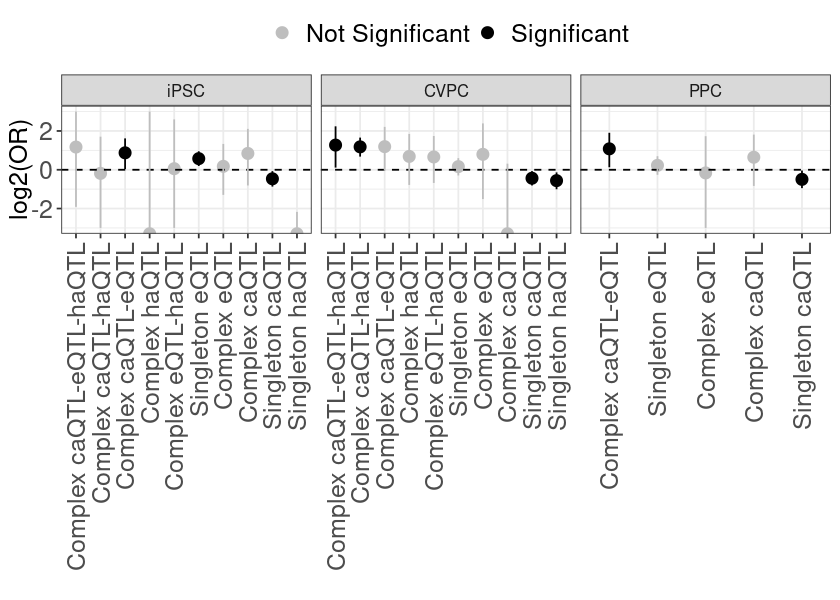

In [33]:
psize(w = 7, h = 5)
toplot = b_data[ b_data$tissue != "All tissues",]
toplot$qtl_combo = gsub("Module","Complex",toplot$qtl_combo)
order = b_data %>% filter(tissue %like% "All") %>% arrange(log2(estimate))
order2 = gsub("Module","Complex",rev(order$qtl_combo))
toplot$qtl_combo = factor(toplot$qtl_combo, levels = order2)
toplot$tissue = factor(toplot$tissue, levels = c("iPSC","CVPC","PPC"))
toplot$logci1[ toplot$logci1 < -3 ] =-3
toplot$logci2[ toplot$logci2 > 3 ] =3
toplot$is_sig = ifelse(toplot$is_sig == F, "Not Significant", "Significant")
ggplot(toplot, aes(x = qtl_combo, y = log2(estimate), color = is_sig)) + 
    geom_point(size = 3) + 
    facet_wrap(.~tissue, nrow = 1, scales = "free_x") + 
    theme_bw2 + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
          strip.text = element_text(size = 10), legend.title=element_blank()) + 
    geom_hline(yintercept = 0, linetype = "dashed") + 
    xlab("") + ylim(-3,3) + 
    scale_color_manual(values = c("gray", "black")) +
    geom_segment(data = toplot %>% filter(is_sig == "Not Significant"), aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "grey") + 
    geom_segment(data = toplot %>% filter(is_sig == "Significant"), aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "black") +
    ylab("log2(OR)") 